In [1]:
import io
import sys
PATH = 'C:/Users/danie/Documents/U/6to Semestre/Inteligencia Artificial/3er Corte/PLN'
DIR_DATA = '../Inteligencia Artificial/3er Corte/PLN/data/input/'
sys.path.append(PATH) if PATH not in list(sys.path) else None
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing

from sklearn.pipeline import FeatureUnion
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler


from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score

from logic.utils import Utils
from logic.classifiers import Classifiers
from logic.text_processing import TextProcessing
from logic.lexical_vectorizer import LexicalVectorizer
from root import DIR_RESULTS

# Variable initialization 

In [2]:
lang = 'es'
iteration = 10
fold = 10
classifiers = Classifiers.dict_classifiers
tp = TextProcessing(lang=lang)
lv = LexicalVectorizer(lang=lang, text_processing=tp)
ut = Utils(lang=lang, text_processing=tp)

# Import data

In [3]:
print('+ Import training...')
x, y = ut.get_data(file_name='tass2020_emotion_train')
print('+ Import test...')
x_eval, y_eval = ut.get_data(file_name='tass2020_emotion_dev')

+ Import training...
		 - Dataset size :(x: 5886 , y: 5886)
+ Import test...
		 - Dataset size :(x: 857 , y: 857)


# Feature extraction

In [4]:
bow_vector = CountVectorizer(analyzer='word', ngram_range=(2, 2), min_df=10)
preprocessor = FeatureUnion([('bow_vector', bow_vector), ('lex_vector', lv)])

preprocessor.fit(x)
preprocessor.fit(x_eval)

x = preprocessor.transform(x)
x_eval = preprocessor.transform(x_eval)

print('- train:\n', sorted(Counter(y).items()))
print('- test: \n', sorted(Counter(y_eval).items()))

- train:
 [('anger ', 600), ('disgust ', 113), ('fear ', 67), ('joy ', 1270), ('others', 1), ('others ', 2888), ('sadness ', 706), ('surprise ', 241)]
- test: 
 [('anger ', 87), ('disgust ', 16), ('fear ', 10), ('joy ', 185), ('others ', 421), ('sadness ', 103), ('surprise ', 35)]


# Over Sampling

In [5]:
k_fold = ShuffleSplit(n_splits=fold, test_size=0.25, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
ros_train = RandomOverSampler(random_state=1000)
x_train, y_train = ros_train.fit_resample(x_train, y_train)
x_test, y_test = ros_train.fit_resample(x_test, y_test)
print('- train:\n', sorted(Counter(y_train).items()))
print('- test:\n', sorted(Counter(y_test).items()))

- train:
 [('anger ', 2022), ('disgust ', 2022), ('fear ', 2022), ('joy ', 2022), ('others', 2022), ('others ', 2022), ('sadness ', 2022), ('surprise ', 2022)]
- test:
 [('anger ', 866), ('disgust ', 866), ('fear ', 866), ('joy ', 866), ('others ', 866), ('sadness ', 866), ('surprise ', 866)]


In [7]:
shape = x_train.shape[1:]

scaler = StandardScaler(with_mean=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_eval = scaler.transform(x_eval)

In [8]:
lb = LabelEncoder()
y_train = lb.fit_transform([i.rstrip() for i in y_train.to_list()])
y_eval = lb.transform([i.rstrip() for i in y_eval.to_list()])
y_test = lb.transform([i.rstrip() for i in y_test.to_list()])

In [9]:
x_train, y_train

(<16176x120 sparse matrix of type '<class 'numpy.float64'>'
 	with 178421 stored elements in Compressed Sparse Row format>,
 array([3, 5, 3, ..., 6, 6, 6], dtype=int64))

# NN Architecture

In [10]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.Input(shape=shape),
                                 keras.layers.Dense(21, activation="softmax"),
                                 keras.layers.Dense(14, activation="relu"),
                                 keras.layers.Dense(7, activation="softmax")
                                ])
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                2541      
                                                                 
 dense_1 (Dense)             (None, 14)                308       
                                                                 
 dense_2 (Dense)             (None, 7)                 105       
                                                                 
Total params: 2,954
Trainable params: 2,954
Non-trainable params: 0
_________________________________________________________________


# Training

In [11]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
accuracies_scores = []
for train_index, test_index in tqdm(cv.split(x_train, y_train), total=cv.get_n_splits(), desc="k-fold"):
    data_train = x_train[train_index]
    target_train = y_train[train_index]

    data_test = x_train[test_index]
    target_test = y_train[test_index]

    history = model.fit(data_train, target_train, verbose=0, epochs=20)
    predict = model.predict(data_test)

k-fold:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\danie\anaconda3\envs\RNN-PLN\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 21), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
k-fold: 100%|██████████| 30/30 [13:33<00:00, 27.11s/it]


# Result

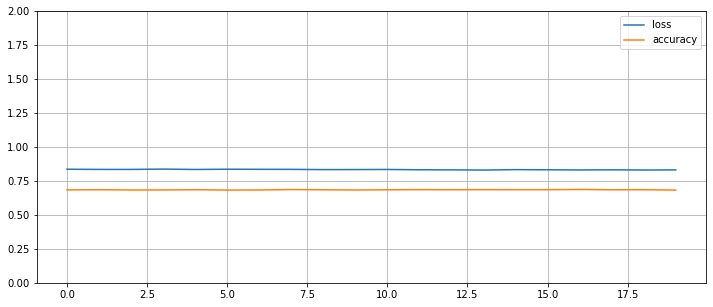

In [12]:
pd.DataFrame(history.history).plot(figsize=(12, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [13]:
score = model.evaluate(x_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

y_predict = []
for features in tqdm(x_test):
    features = features.reshape(1, -1)
    value_prob = model.predict(features)
    value = np.argmax(value_prob, axis=1)
    y_predict.append(value)

accuracy_predict = accuracy_score(y_test, y_predict)
print('Accuracy: {0}'.format(round(np.mean(accuracy_predict), 2)))
print(classification_report(y_test, y_predict))

190/190 [==============================] - 1s 3ms/step - loss: 7.2841 - accuracy: 0.2313
Test Score: 7.284061431884766
Test Accuracy: 0.23127681016921997


6062it [02:45, 36.67it/s]

Accuracy: 0.23
              precision    recall  f1-score   support

           0       0.17      0.15      0.15       866
           1       0.33      0.26      0.29       866
           2       0.00      0.00      0.00       866
           3       0.23      0.32      0.27       866
           4       0.22      0.30      0.25       866
           5       0.25      0.35      0.29       866
           6       0.24      0.24      0.24       866

    accuracy                           0.23      6062
   macro avg       0.21      0.23      0.21      6062
weighted avg       0.21      0.23      0.21      6062

